In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle as pk
import json
import hashlib
import collections
from tqdm.notebook import tqdm
from pyvis.network import Network

In [2]:
class Cluster:
    def __init__(self,proteins):
        self.proteins = proteins

    def __len__(self):
        return len(self.proteins)

    def __repr__(self):
        reprStr = "Cluster of {} [{},{},...] (hash {})".format(len(self), self.proteins[0], self.proteins[1], hash(self))
        if hasattr(self, 'G'):
            reprStr += "\nTriangles: {}\nMax Degree: {}".format(self.triangles(), max(self.G.degree(), key=lambda x: x[1])[1])
        if hasattr(self, 'GO_terms'):
            reprStr += "\nTop Terms:\n\t{}".format('\n\t'.join(
                    ['{} ({})'.format(i[0], i[1]) for i in self.get_top_terms(5)]
            ))
        return reprStr

    def __hash__(self):
        return int(hashlib.md5(''.join(self.proteins).encode()).hexdigest(), 16)

    def to_dict(self):
        D = {}
        D['id'] = hash(self)
        D['proteins'] = []
        for p in self.proteins:
            pD = {}
            pD['name'] = p
            if hasattr(self, 'GO_DB'):
                pD['go'] = self.GO_DB[self.GO_DB['seq'] == p]['GO_ids'].values[0]
            D['proteins'].append(pD)
        if hasattr(self, 'GO_DB'):
            D['go'] = sorted([{"id": i.ID, "desc": i.name, "freq": self.GO_terms[i]} for i in self.GO_terms], key = lambda x: x['freq'], reverse=True)
        if hasattr(self,'G'):
            D['graph'] = list(self.G.edges())
        return D

    def to_json(self):
        return json.dumps(self.to_dict())

    def add_GO_terms(self, go_db, GO_OBJECTS):
        self.GO_terms = {}
        self.GO_DB = go_db
        for prot in self.proteins:
            goIds = go_db[go_db['seq'] == prot]['GO_ids'].values[0]
            if goIds is None or len(goIds) == 0:
                continue
            for gid in goIds:
                if gid in GO_OBJECTS:
                    goObj = GO_OBJECTS[gid]
                # except KeyError:
                #     GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gid})
                #     goObj = GO_OBJECTS[gid]
                    goCount = self.GO_terms.setdefault(goObj,0)
                    self.GO_terms[goObj] = goCount + 1

    def get_proteins_by_GO(self, GO_id):
        return [p for p in self.proteins if GO_id in prot_go_db.loc[p,'GO_ids']]

    def get_GO_by_protein(self, protein):
        assert protein in self.proteins, "{} not in cluster".format(protein)
        return [gt for gt in coi.GO_terms if gt.ID in prot_go_db.loc[protein,'GO_ids']]

    def get_top_terms(self,N):
        if not hasattr(self, 'GO_terms'):
            raise NotImplementedError("GO Terms have not been added yet.")
        GOlist = list(self.GO_terms.keys())
        if N == -1:
            N = len(GOlist)
        sortedList = sorted(GOlist,key=lambda x: self.GO_terms[x],reverse=True)[:N]
        return list(zip(sortedList, [self.GO_terms[i] for i in sortedList]))

    def set_graph(self,G):
        self.G = G.subgraph(self.proteins)

    def triangles(self):
        return sum([i for i in nx.triangles(self.G).values()]) / 3

    def draw_degree_histogram(self,draw_graph=True):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        G = self.G
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())
        fig, ax = plt.subplots()
        plt.bar(deg, cnt, width=0.80, color='b')

        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)

        # draw graph in inset
        if draw_graph:
            plt.axes([0.4, 0.4, 0.5, 0.5])
            pos = nx.spring_layout(G, k=0.15,iterations=10)
            plt.axis('off')
            nx.draw_networkx_nodes(G, pos, node_size=20)
            nx.draw_networkx_edges(G, pos, alpha=0.4)
        plt.show()

    # def draw_graph(self):
    #     if not hasattr(self,'G'):
    #         raise ValueError('Run .set_graph() method on this cluster first')
    #     G = self.G
    #     nx.draw_kamada_kawai(G, with_labels=True,node_size=600, font_size=8)
    
    def draw_graph(self, xsize=800, ysize=800, notebook=True, cdn_resources='remote'):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        nt = Network(f'{xsize}px', f'{ysize}px',notebook=notebook, cdn_resources=cdn_resources)
        nt.from_nx(self.G)
        return nt.show(f'{hash(self)}.html')
    
def read_cluster_objects(infile,sep=','):
    clusts = []
    with open(infile,'r') as f:
        for line in f:
            clusts.append(Cluster(line.strip().split(sep)))
    return clusts

def cluster_from_json(jsonString, GO_OBJECTS):
        clust = Cluster([])
        D = json.loads(jsonString)
        clust.proteins = [i['name'] for i in D['proteins']]
        clust.GO_terms = {}
        for goDict in D['go']:
            gid = goDict['id']
            gdesc = goDict['desc']
            try:
                goObj = GO_OBJECTS[gid]
            except KeyError:
                GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gdesc})
                goObj = GO_OBJECTS[gid]
            clust.GO_terms[goObj] = goDict['freq']
        try:
            edgeList = D['graph']
            G = nx.Graph()
            for e in edgeList:
                G.add_edge(*e)
            clust.G = G
        except KeyError:
            pass
        return clust

In [24]:
class GO:
    def __init__(self, ID, features):
        self.ID = ID
        self.D = features
        self.name = features['name']

    def __repr__(self):
        return '{} - <{}>'.format(self.ID, self.name)

    def __eq__(self, other):
        return self.ID == other.ID

    def __hash__(self):
        return hash(self.ID)
    
    def __lt__(self, other):
        return self.ID < other.ID

def extract_GO_id_from_list(l):
    if isinstance(l,list):
        return [i.split('|')[0] for i in l]
    else:
        return None

def read_GO_obo(infile):
    terms = {}
    with open(infile,'r') as f:
        for line in f:
            tDict = {}
            line = line.strip()
            if line == "[Term]":
                line = f.readline().strip().split(': ')
                while not line == ['']:
                    tDict[line[0]] = ''.join(line[1:])
                    line = f.readline().strip().split(': ')
                for k,v in tDict.items():
                    k = k.strip()
                    v = v.strip()
                    tDict[k] = v
                terms[tDict['id']] = GO(tDict['id'], tDict)
    return terms

def GO_search(clusters, GO_term, GO_OBJECTS, N=20):
    if isinstance(GO_term,str):
        GO_term = GO_OBJECTS[GO_term]
    return [c for c in clusters if GO_term in [i[0] for i in c.get_top_terms(N)]]

def protein_search(clusters, protein_list):
    if isinstance(protein_list, str):
        protein_list = [protein_list]
    plist = [c for c in clusters if np.array([p in c.proteins for p in protein_list]).all()]
    if len(plist) == 0:
        return None
    elif len(plist) == 1:
        return plist[0]
    else:
        return plist
    
def triangle_search(clusters, min_triangles=0, max_triangles=np.infty):
    return [c for c in clusters if c.triangles() >= min_triangles and c.triangles() <= max_triangles]

def node_search(clusters, min_nodes=0, max_nodes=np.infty):
    return [c for c in clusters if len(c) >= min_nodes and len(c) <= max_nodes]

In [85]:
net_name = 'Pdam' # TODO: options: 'Pdam', 'SymbC1'
BASE_DIR = '..'
DATA_DIR = f'{BASE_DIR}/data/'
OUTPUT_DIR = f'{BASE_DIR}/results/'

edge_weight_thresh = 0.5
n_connecting_edges = 10
go_db_file =f"{DATA_DIR}/go.obo"
goslim_db_file = f"{DATA_DIR}/goslim_generic.obo"
interactionFile = f'{DATA_DIR}/{net_name}_predictions_positive.tsv'
clusters_file = f"{OUTPUT_DIR}{net_name}.clusters.csv"

---

## Load Clusters

In [116]:
clusters = read_cluster_objects(clusters_file)

In [117]:
protein_names = set()
for c in clusters:
    protein_names = protein_names.union(c.proteins)

In [118]:
G_init = nx.read_weighted_edgelist(interactionFile)
print('Selecting subgraph...')
G_sub = G_init.subgraph(protein_names)
print('Filtering edges with confidence threshold {}...'.format(edge_weight_thresh))
G = nx.Graph()
for (u,v,d) in tqdm(G_sub.edges.data()):
    if d['weight'] >= edge_weight_thresh:
        G.add_edge(u,v,weight=d['weight'])
degrees = [i[1] for i in list(G.degree())]

Selecting subgraph...
Filtering edges with confidence threshold 0.5...


  0%|          | 0/215706 [00:00<?, ?it/s]

In [119]:
for i in clusters:
    i.set_graph(G)

---

## Add Function to Clusters

In [120]:
def clean_GO_map(f):
    seqDb = pd.read_csv(f,sep=',')
    seqDb.columns = ['seq','manual_annot','pfam_list','GO_list']
    seqDb['GO_str'] = seqDb['GO_list']
    seqDb['GO_list'] = seqDb['GO_str'].str.split(';')
    def extract_GO_id_from_list(l):
        if isinstance(l,list):
            return [i.split('|')[0] for i in l]
        else:
            return None
    seqDb['GO_ids'] = seqDb['GO_list'].apply(extract_GO_id_from_list)
    seq2GO = seqDb[['seq','GO_ids']]
    seq2GO.columns = ['seq','GO_ids']
    return seq2GO

In [138]:
pdamMap = clean_GO_map('~/Work/Coral_Experimental_Validation/Pdam_CV3_E7_Predictions/Pdam_GO_map.csv')

In [139]:
GO_OBJECTS = read_GO_obo(go_db_file)
GO_SLIM = read_GO_obo(goslim_db_file)
print('Adding GO Annotations...')
for clust in tqdm(clusters):
    clust.add_GO_terms(pdamMap,GO_SLIM)
clusters.sort(key=lambda x: len(x), reverse=True)

Adding GO Annotations...


  0%|          | 0/582 [00:00<?, ?it/s]

In [140]:
go_assigned = set()
for c in tqdm(clusters):
    for g in c.GO_terms.keys():
        go_assigned.add(g.ID)
go_assigned = sorted(list(go_assigned))
len(go_assigned)

  0%|          | 0/582 [00:00<?, ?it/s]

28

In [141]:
proteins_in_clusters = []
for c in tqdm(clusters):
    proteins_in_clusters.extend(c.proteins)

  0%|          | 0/582 [00:00<?, ?it/s]

In [142]:
from scipy.spatial.distance import jaccard
from sklearn.metrics import jaccard_score

In [143]:
def protein_GO_bit_vector(protein_id, go_map, full_go_list,id_col='seq',go_col='GO_ids'):
    go_bv = np.zeros(len(full_go_list))
    prot_go = go_map.set_index(id_col).loc[protein_id, go_col]
    if prot_go is not None:
        for gid in prot_go:
            if gid in full_go_list:
                go_bv[full_go_list.index(gid)] = 1
    return go_bv

## BEFORE PERMUTATION

In [262]:
for i in go_assigned:
    print(i)

GO:0001618
GO:0003014
GO:0003016
GO:0003677
GO:0003723
GO:0003774
GO:0003924
GO:0005198
GO:0006281
GO:0006954
GO:0007155
GO:0008092
GO:0008289
GO:0016209
GO:0016491
GO:0016740
GO:0016787
GO:0016829
GO:0016853
GO:0016874
GO:0031386
GO:0042060
GO:0042393
GO:0044183
GO:0045735
GO:0048018
GO:0050877
GO:0060090


In [144]:
protein_GO_bvs = {}
for pid in tqdm(proteins_in_clusters):
    protein_GO_bvs[pid] = protein_GO_bit_vector(pid, pdamMap, go_assigned)

  0%|          | 0/8448 [00:00<?, ?it/s]

In [145]:
from itertools import combinations

In [188]:
cluster_jaccards = {}

for c in tqdm(clusters):
    cjaccard = []
    for (p1, p2) in combinations(c.proteins, 2):
        jc = 1 - jaccard(protein_GO_bvs[p1], protein_GO_bvs[p2])
        cjaccard.append(jc)
    cluster_jaccards[hash(c)] = np.array(cjaccard)

  0%|          | 0/582 [00:00<?, ?it/s]

## AFTER PERMUTATION

In [204]:
pdamMap["GO_permuted"] = pdamMap["GO_ids"].sample(frac=1).values

In [205]:
protein_GO_bvs_perm = {}
for pid in tqdm(proteins_in_clusters):
    protein_GO_bvs_perm[pid] = protein_GO_bit_vector(pid, pdamMap, go_assigned, go_col="GO_permuted")

  0%|          | 0/8448 [00:00<?, ?it/s]

In [206]:
cluster_jaccards_perm = {}

for c in tqdm(clusters):
    cjaccard = []
    for (p1, p2) in combinations(c.proteins, 2):
        jc = 1 - jaccard(protein_GO_bvs_perm[p1], protein_GO_bvs_perm[p2])
        cjaccard.append(jc)
    cluster_jaccards_perm[hash(c)] = np.array(cjaccard)

  0%|          | 0/582 [00:00<?, ?it/s]

## Plot

In [207]:
from scipy.stats import ttest_ind
def one_tail_ttest(null, greater):
    tstat, p = ttest_ind(null, greater)
    if tstat > 0:
        return tstat, (1-(p/2))
    else:
        return tstat, p/2

In [208]:
len(cluster_jaccards)

582

In [209]:
phil_mean = [i.mean() for i in cluster_jaccards.values()]
permute_mean = [i.mean() for i in cluster_jaccards_perm.values()]

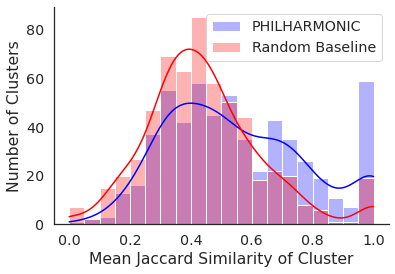

In [213]:
sns.set_palette("colorblind")
sns.set(style="white", font_scale=1.3)
kde = True
sns.histplot( phil_mean , color="blue", label="PHILHARMONIC", bins=np.arange(0,1.05,0.05), alpha=0.3, kde=True)
sns.histplot( permute_mean , color="red", label="Random Baseline", bins=np.arange(0,1.05,0.05), alpha=0.3, kde=True)
tstat, p = one_tail_ttest(permute_mean, phil_mean)
# plt.title("Functional Enrichment: PHILHARMONIC (p={:.3})".format(p))
plt.xlabel("Mean Jaccard Similarity of Cluster")
plt.ylabel("Number of Clusters")
plt.legend()
sns.despine()
plt.savefig(f"{OUTPUT_DIR}{net_name}.func_enrichment.png",bbox_inches='tight',dpi=300,transparent=True)
plt.show()

In [234]:
def clean_top_terms(c, return_counts=True, n_filter=3):
    csize = len(c)
    tt = c.get_top_terms(1)
    if len(tt):
        if tt[0][1] < n_filter:
            pass
        elif return_counts:
            return (tt[0][0].name, tt[0][1], csize)
        else:
            return tt[0][0].name
    if return_counts:
        return ('No function', None, csize)
    else:
        return 'No function'
    
cluster_top_terms = {hash(c): clean_top_terms(c, return_counts=False) for c in clusters}

In [237]:
from collections import Counter
counter = Counter(cluster_top_terms.values())
counter

Counter({'lipid binding': 14,
         'inflammatory response': 84,
         'DNA binding': 15,
         'GTPase activity': 30,
         'virus receptor activity': 11,
         'No function': 340,
         'cell adhesion': 21,
         'DNA repair': 25,
         'transferase activity': 1,
         'RNA binding': 6,
         'ligase activity': 9,
         'protein tag activity': 5,
         'histone binding': 4,
         'respiratory system process': 4,
         'molecular adaptor activity': 7,
         'cytoskeletal motor activity': 5,
         'wound healing': 1})

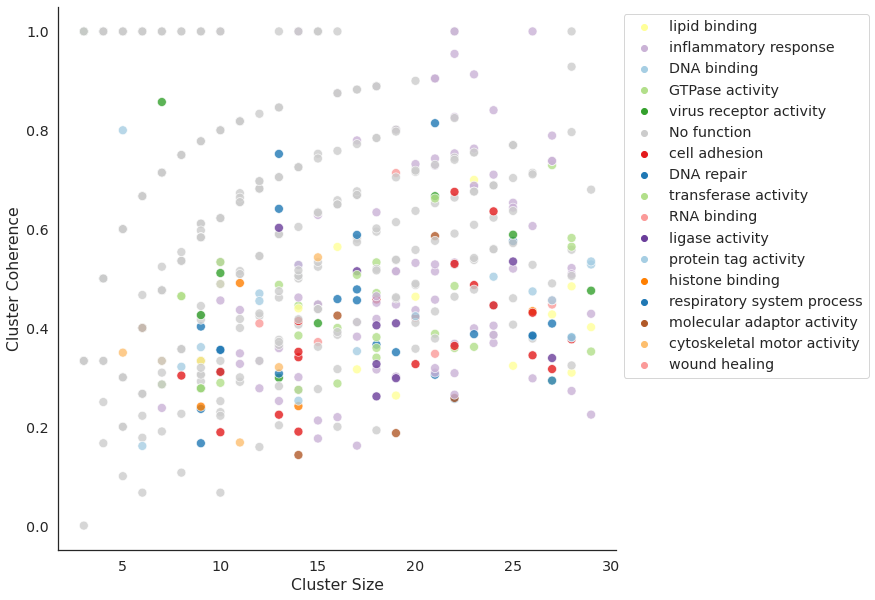

In [260]:
sns.set(style='white', font_scale=1.3)
fig,ax = plt.subplots(figsize=(10,10))

clens = [len(c) for c in clusters]
cjacc = [np.mean(cluster_jaccards[hash(c)]) for c in clusters]
cfunc = [cluster_top_terms[hash(c)] for c in clusters]
color_map = {k:v for k,v in zip(sorted(set(cfunc)), sns.color_palette("Paired", len(set(cfunc))))}
color_map["No function"] = (0.8,0.8,0.8)

sns.scatterplot(x=clens, y=cjacc, s=80, alpha=0.8, hue=cfunc, palette=color_map, ax=ax)
plt.xlabel('Cluster Size')
plt.ylabel('Cluster Coherence')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.show()

In [54]:
jaccard(
    protein_GO_bit_vector('pdam_00020376-RA', pdamMap, go_assigned),
    protein_GO_bit_vector('pdam_00020370-RA', pdamMap, go_assigned)
)

0.0

In [51]:
protein_GO_bit_vector('pdam_00001358-RA', pdamMap, go_assigned).sum()

54.0

In [34]:
go_assigned.index('GO:0000006')

0

In [20]:
len(go_assigned)

6668

In [16]:
pdamMap.sort_values(by='seq')

,seq,GO_ids,GO_shuffled
6137,pdam_00000001-RA,"[GO:0005031, GO:0071316, GO:0070555, GO:000695...","[GO:0036479, GO:0005524, GO:0005525, GO:002202..."
5434,pdam_00000002-RA,"[GO:0017176, GO:0036479, GO:0046481, GO:000552...","[GO:0043022, GO:0030433, GO:0060416, GO:007552..."
5433,pdam_00000003-RA,"[GO:0036479, GO:0005524, GO:0005525, GO:002202...","[GO:0070336, GO:0050798, GO:0007499, GO:003256..."
2949,pdam_00000006-RA,"[GO:0043022, GO:0003729, GO:0071357, GO:007136...","[GO:0005547, GO:0031098, GO:0070300, GO:009013..."
2947,pdam_00000007-RA,"[GO:0043022, GO:0005052, GO:0003729, GO:001069...","[GO:0070336, GO:0032567, GO:0048755, GO:000827..."
...,...,...,...
3014,pdam_00026064-RA,"[GO:0005052, GO:0010698, GO:0036494, GO:003545...","[GO:0047366, GO:0047364, GO:0047685, GO:004513..."
4893,pdam_00026066-RA,"[GO:0005041, GO:0071603, GO:0036363, GO:000820...","[GO:0017080, GO:0005111, GO:0070075, GO:000820..."
58,pdam_00026073-RA,"[GO:0007155, GO:0048771, GO:0008201, GO:007000...","[GO:0036518, GO:0036517, GO:0048561, GO:190237..."
152,pdam_00026075-RA,"[GO:0007155, GO:0048771, GO:0008201, GO:007000...","[GO:0014822, GO:0097535, GO:0002508, GO:007145..."


In [ ]:
def 